# Rate vs Cross section

In general we can write the relation between Rate, $\frac{dR}{d\Omega}$, and the Cross Section, $\frac{d\sigma}{d\Omega}$: 

$$
\frac{dR}{d\Omega} = \epsilon_{spettrometer} N_c \Phi \frac{d\sigma}{d\Omega}
$$
 
where $N_c$ is the number of scattering center and $\Phi$ is the flux of the particles. 

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
r_e = 2.817e-13  # Classical electron radius in cm
m_e = 511  # Electron rest mass energy in keV
alpha = 1 / 137  # Fine-structure constant (dimensionless)
N_a = 6.022e23 # mol^(-1)

# Target parameters
# For a Cu target
rho = 8.96 #g/cm^3
Z = 29 #number of electrons
MM = 63.546 #g/mol

## Calculus of the number of scattering center
We can think that at first approximation, $N_c$ is the number of electrons in the illuminated region of the target, and so it follow the following equation:
$$
N_c = \rho \frac{N_aZ}{\text{MM}}V
$$
where: 
- $\rho$ is the density of the scattering target
- $N_a$ is the Avogadro number
- $Z$ is the atomic number of the scattering target
- $\text{MM}$ is the molar mass of the scattering target
- $V$ is the volume

In [60]:
def cross_section_thomson():
    """
    Calculate the Thomson cross-section, which represents the scattering 
    of electromagnetic waves by free electrons at low photon energies.

    :return: Thomson cross-section in square meters.
    """
    return (8 / 3) * np.pi * r_e ** 2


def cross_section_photoelectric(energy: float, Z: float) -> float:
    """
    Calculate the photoelectric cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Photoelectric cross-section in square meters.
    """
    bond_energy = 0.0047  # Example binding energy in keV
    gamma = (energy + m_e - bond_energy) / m_e 
    c = (3 / 2) * (alpha ** 4) * cross_section_thomson()  # Coefficient based on fine-structure constant

    return c * (
        ((Z * m_e / energy) ** 5) *
        (gamma ** 2 - 1) ** (3/2) *
        (
            (4/3) + (gamma * (gamma - 2) / (gamma + 1)) *
            (
                1 - (1 / (2 * gamma * (gamma ** 2 - 1)**(1/2))) *
                np.log((gamma + (gamma ** 2 - 1)**(1/2)) / (gamma - (gamma ** 2 - 1)**(1/2)))
            )
        )
    )


def cross_section_compton(energy: float, Z: float) -> float:
    """
    Calculate the Compton scattering cross-section for a photon interacting with a material.

    :param photon: Photon object containing energy information (energy in MeV).
    :param Z: Atomic number of the material.
    :return: Compton cross-section in square meters.
    """
    epsilon = energy / m_e  # Ratio of photon energy to electron rest mass energy

    # Define calculations for high and low energy regimes
    # These calculations are already vectorized if epsilon is an array
    
    # High energy part
    c_high = 2 * np.pi * r_e ** 2  # Coefficient based on Thomson cross-section
    # Handle potential division by zero if epsilon can be zero or very small.
    # For energy > 100 MeV, epsilon is large.
    term1_high = (1 + epsilon) / epsilon ** 2
    term2_high = (2 * (1 + epsilon) / (1 + 2 * epsilon)) - (np.log(1 + 2 * epsilon) / epsilon)
    term3_high = np.log(1 + 2 * epsilon) / (2 * epsilon)
    term4_high = (1 + 3 * epsilon) / (1 + 2 * epsilon) ** 2
    result_high = c_high * Z * (term1_high * term2_high + term3_high - term4_high)

    # Low energy part
    c_low = cross_section_thomson() 
    poly_term = (
        1 + 2 * epsilon + (6/5) * epsilon ** 2 - (1/2) * epsilon ** 3 +
        (2/7) * epsilon ** 4 - (6/35) * epsilon ** 5 + (8/105) * epsilon ** 6 + (4/105) * epsilon ** 7
    )
    result_low = c_low * Z * (1 / (1 + 2 * epsilon) ** 2) * poly_term
    
    # Use np.where to choose between high and low energy calculations
    return np.where(energy > 100, result_high, result_low)

def attenuation_factor(total_cross_section: float, density_of_scattering_centers: float) -> float:
    """
    Calculate the attenuation factor for a photon traveling through a material.

    :param total_cross_section: Total cross-section for the interaction (in cm²).
    :param scattering_target: Material properties (e.g., density, molar mass).
    :return: Attenuation factor (inverse mean free path).
    """
    return total_cross_section * density_of_scattering_centers # cm^-1

def attenuation_length(energy: float, Z: int) -> float:
    """
    Calculate the attenuation length for a photon traveling through a material.

    :param attenuation_factor: Attenuation factor (inverse mean free path).
    :return: Attenuation length in cm.
    """
    cross_section = cross_section_photoelectric(energy, Z) + cross_section_compton(energy, Z)
    density_of_scattering_centers = rho * N_a / MM  # g/cm^3
    mu = attenuation_factor(cross_section, density_of_scattering_centers)
    return 1 / mu  # cm

def compton_energy(theta):
    """
    Calculate the energy of a photon after Compton scattering.
    
    :param theta: Scattering angle in radians.
    :return: Energy of the photon after scattering in keV.
    """
    return 511 / (2 - np.cos(theta)) #keV


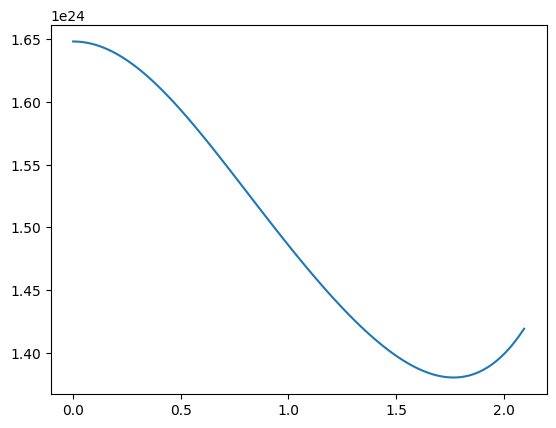

In [61]:
r_gate = 1.27  #cm
d_gate_source = 16 #cm
d_sorg_targ = 5 #cm
target_width = 1 #cm 
beta_2 = np.arctan(r_gate / d_gate_source)
r = d_sorg_targ * np.tan(beta_2)

def A(theta):
    d = (2 * r + target_width * np.tan(beta_2)) / np.cos(theta/2) - (target_width/2) * (np.tan(theta/2 + beta_2) - np.tan(theta/2 - beta_2))
    return np.pi * d * r /2 

def V(theta):
    return A(theta) * attenuation_length(compton_energy(theta), Z)  # cm^3

def N_c(theta):
    #Calculus of the number of atoms in the target
    N_c = rho * (N_a * Z / MM) * V(theta)
    return N_c

import matplotlib.pyplot as plt

thetas = np.linspace(0, (2/3) * np.pi, 100)
plt.plot(thetas, N_c(thetas))
plt.show()

## Calculus of the flux
We can think at the flux as the number of particle that pass through the detector surface per seconds, so we can write: 


$$
\Phi = \frac{S(t)\text{BR}}{A_{gate}}\frac{\Delta\Omega}{4\pi}\epsilon_{gate}(511)
$$

where: 
- $S(t)$ is the activity of the source in Bq
- $\text{BR}$ is the branching ratio of the 511 keV photon
- $A_{gate}$ is the detector surface 
- $\frac{\Delta\Omega}{4\pi}$ is the solid angle
- $\epsilon_{gate}(511)$ is the efficiency of the gate detector for the 511 keV photon

In [62]:
Omega = 2 * np.pi * (1 - np.cos(beta_2)) #sr

def flux():
    S = 175000 #Bq
    BR = 0.903 * 2

    epsilon_gate = 0.17

    r_gate = 1.27  #cm
    A_gate = np.pi * r_gate ** 2 #cm^2

    # Calculus of the flux
    flux = (S * BR/A_gate) * (Omega / (4 * np.pi)) * epsilon_gate #cm^-2 s^-1
    return flux

print(flux())

16.62296997338231


## Calculus of the cross section
The cross section has to be the Klein-Nshina formula: 

$$
\frac{d\sigma}{d\Omega} = \frac{r_e^2}{2}\bigg(\frac{\omega'}{\omega}\bigg)^2\bigg[\frac{\omega'}{\omega} + \frac{\omega}{\omega'} - \sin^2(\theta)\bigg]
$$


## Calculus of Rate vs Cross Section
We can resume all the upper calculus to find the constant between the Rate and the Cross section: 

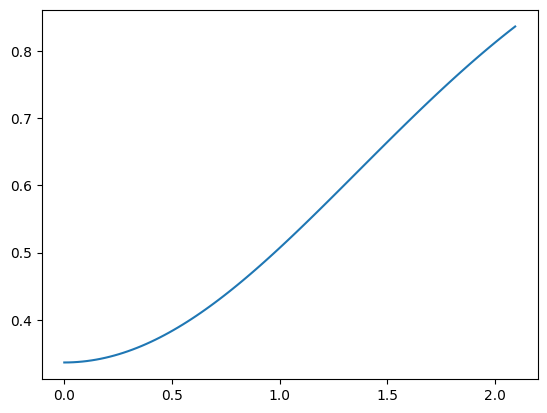

In [63]:
def epsilon_spettrometer(theta): # formula non è corretta
    A = 0.42719
    B = 0.58613
    C = 1.69372
    D = 0.07002

    E  = compton_energy(theta) * 1e-3 #MeV

    return A * pow(E, -B) * np.exp(-C * E) + D

plt.plot(thetas, epsilon_spettrometer(thetas))
plt.show()

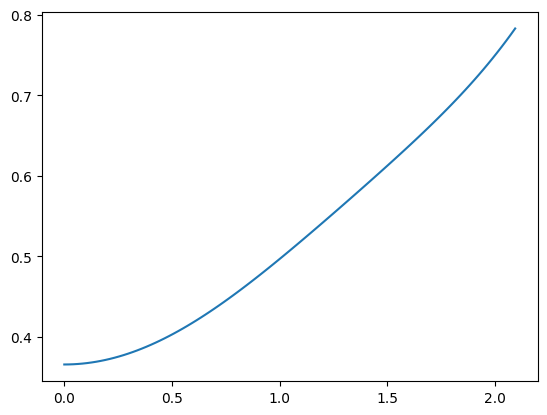

In [64]:
def const (theta):
    return (r_e ** 2 / 2) * N_c(theta) * flux() * epsilon_spettrometer(theta)

plt.plot(thetas, const(thetas))
plt.show()

## Complete Klein-Nishina

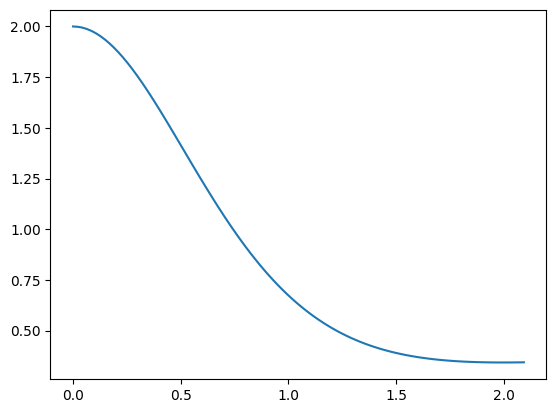

In [65]:
def klein_nishina(theta):
    E = compton_energy(theta)
    r = E / 511
    return r ** 2 * (r + 1/r - np.sin(theta) ** 2)

plt.plot(thetas, klein_nishina(thetas))
plt.show()

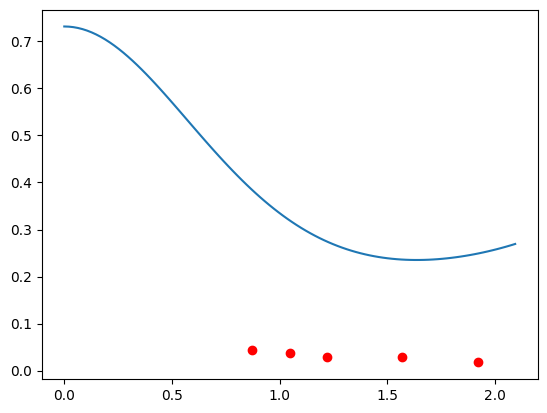

In [ ]:
def rate_function(theta):
    return const(theta) * klein_nishina(theta)


angles = np.array([ 50, 60, 70, 90, 110]) * np.pi / 180
measured_rates = np.array([ 0.0448, 0.03729, 0.0280, 0.03001, 0.01740])

plt.plot(thetas, rate_function(thetas))
plt.scatter(angles, measured_rates, color='red')
plt.show()